In [ ]:
import geopandas as gpd
from shapely.geometry import Point, LineString, Polygon
import networkx as nx
import pandas as pd
import datetime
# from datetime import datetime
import numpy as np
from shapely import wkt
from shapely.geometry import Point, Polygon, shape
from IPython.display import GeoJSON
from shapely.ops import unary_union
import json, math
from collections import defaultdict, ChainMap
import fiona
from itertools import chain

In [ ]:
ps_data = pd.read_stata('../Data/nhts-2013-v1/stata/nhts-2013-person-v1-20140718.dta', convert_categoricals=False)

ps_data['PERSONNO'] = ["%02d" % x for x in ps_data['PERSONNO']]
ps_data

,UQNO,PERSONNO,TAZCODE,Pr_code,B_NIGHTS,GENDER,D_AGE,RACE,F_HAVELICENCE,G_MOTORCYC,...,Q423TOTCST,Q69TOTCST,undisab,disab,Type,Quintile,totmhinc,Msal,Oldmsal,FULL_CALWGT
0,160100091000004501,01,9001,1,1,2,35,2,2,8,...,888888,888888,0,0,3,3,2100,888888888,888888888,256.707531
1,160100091000004501,02,9001,1,1,1,38,2,2,8,...,999999,888888,0,0,3,3,2100,2100,2100,256.707531
2,160100091000004501,03,9001,1,1,2,9,2,9,9,...,888888,888888,0,0,3,3,2100,888888888,888888888,256.707531
3,160100091000009301,01,9001,1,1,1,40,2,2,8,...,888888,888888,0,0,3,4,4192,2096,2096,243.311764
4,160100091000009301,02,9001,1,1,2,32,2,2,8,...,888888,888888,0,0,3,4,4192,2096,2096,243.311764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157268,987106481000011201,01,7002,9,1,2,81,1,2,8,...,888888,888888,1,1,3,2,1480,888888888,888888888,178.376568
157269,987106481000011201,02,7002,9,1,2,30,1,2,8,...,888888,888888,1,1,3,2,1480,888888888,888888888,178.376568
157270,987106481000011201,03,7002,9,1,2,7,1,2,8,...,888888,888888,0,0,3,2,1480,888888888,888888888,178.376568
157271,987106481000012501,01,7002,9,1,2,72,1,2,8,...,888888,888888,0,0,3,3,1200,888888888,888888888,354.767247


In [ ]:
hh_data = pd.read_stata('../Data/nhts-2013-v1/stata/nhts-2013-house-v1-20140718.dta', convert_categoricals=False)
hh_data

,UQNO,Pr_code,Q71MAIND,Q72EXP,Q73SAL,Q73BUSN,Q73REM,Q73PEN,Q73GRANT,Q73AGRIC,...,Q813IFREOF,Q813JWAIT,Q813KFARES,Q813LFACTY,Q813MROADW,Q813NBEHAVE,Q813OSERV,Quintile,totmhinc,FULL_CALWGT
0,160100091000004501,1,1,4,1,2,2,2,2,2,...,8,8,8,8,8,8,8,3,2100,256.707531
1,160100091000009301,1,1,5,1,2,2,2,2,2,...,2,2,2,2,2,9,2,4,4192,243.311764
2,160100091000011701,1,1,6,2,2,2,1,2,2,...,8,8,8,8,8,8,8,3,1200,177.220977
3,160100091000016501,1,1,10,1,2,2,2,1,2,...,8,2,2,8,2,9,2,3,4328,253.784526
4,160100161000000201,1,1,4,1,2,2,2,2,2,...,8,8,8,8,8,8,8,4,4058,164.756074
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43457,987106481000007301,9,1,8,1,1,2,2,1,2,...,1,1,1,1,1,3,1,3,6360,413.335162
43458,987106481000008601,9,1,6,2,2,2,1,1,2,...,2,4,2,4,4,1,2,2,2680,399.467480
43459,987106481000009901,9,1,6,2,2,2,1,1,2,...,4,4,2,2,2,1,1,2,1760,364.815076
43460,987106481000011201,9,1,5,2,2,2,1,1,2,...,4,4,4,2,4,4,2,2,1480,178.376568


## Calculate metrics by visited facility 

In [5]:
for i in ps_data.columns:
    print(i)

UQNO
PERSONNO
TAZCODE
Pr_code
B_NIGHTS
GENDER
D_AGE
RACE
F_HAVELICENCE
G_MOTORCYC
G_CAR
G_HEAVYVEH
Q11ASEE
Q11BHEAR
Q11CWALK
Q11DCONCENTR
Q11ECARE
Q11FCOMM
Q12EYE
Q12HEAR
Q12WALK
Q12WCHAIR
Q12CHRONM
Q12CRUTCH
Q12GUID
Q12PA
Q12OTHR
Q13SOG
Q14OAG
Q14DIS
Q14CSG
Q14CAR
Q14FOST
Q14WARVT
Q14GRN
Q14SOC
Q21MON
Q21TUES
Q21WED
Q21THURS
Q21FRI
Q21SAT
Q21SUN
Q22TRIP
Q23YNOTTRIP
Q24USULWRK
Q24CORSWRK
Q24VFR
Q24TAKE
Q24EDUC
Q24SHOP
Q24LOOKWRK
Q24MEDI
Q24TRADH
Q24WELF
Q24CHURCH
Q24HOME
Q24OTHR
Q25TRAIN
Q25SHOSLZA
Q25BUS
Q25BRT
Q25METTAXI
Q25MINITAXI
Q25LONGTAXI
Q25SEDATAXI
Q25BAKITAXI
Q25CARPAS
Q25CARDRIV
Q25TRUCKPAS
Q25TRUCKDRIV
Q25COMVEH
Q25MBIKE
Q25BICYCLE
Q25ANITRANSP
Q25BOAT
Q25AIRCFT
Q25GAUT
Q25WALK
Q25OTHR
Q26YWALK
Q31HIEDU
Q32ATTE
Q33EDUII
Q34DLRN
Q35APLC
Q35BPROVV
Q35CDISTRCT
Q35dTAZCODE_IMP
Q36DAYS
Q3START_TIMEA
Q38WALKTO
Q39WAIT
Q310WLKEDU
Q3END_TIMEA
Q312MODE1
Q312MODE2
Q312MODE3
Q313MODE1
Q313MODE2
Q313MODE3
Q314MODE1
Q314MODE2
Q314MODE3
Q41WORK
Q42YNOTWRKK
Q43WILTOWRK
Q44APLC
Q44BPROVV


In [6]:
col_lst = [
    'Q24USULWRK', 
    'Q24CORSWRK', 
    'Q24VFR', 
    'Q24TAKE', 
    'Q24EDUC', 
    'Q24SHOP', 
    'Q24LOOKWRK', 
    'Q24MEDI', 
    'Q24TRADH', 
    'Q24WELF', 
    'Q24CHURCH', 
    'Q24HOME', 
    'Q24OTHR', 
]
ps_data['total_trips'] = ps_data[col_lst].sum(axis=1)
ps_data['person_id'] = ps_data['UQNO'] + ps_data['PERSONNO']

ps_data[col_lst].describe()

,Q24USULWRK,Q24CORSWRK,Q24VFR,Q24TAKE,Q24EDUC,Q24SHOP,Q24LOOKWRK,Q24MEDI,Q24TRADH,Q24WELF,Q24CHURCH,Q24HOME,Q24OTHR
count,157273.000000,157273.000000,157273.000000,157273.000000,157273.000000,157273.000000,157273.000000,157273.000000,157273.000000,157273.000000,157273.000000,157273.000000,157273.000000
mean,18.716016,18.481875,18.562379,18.482136,18.808181,18.573074,18.481596,18.477882,18.459653,18.460969,18.501561,19.245102,18.483014
std,35.685613,35.802126,35.761997,35.801590,35.638793,35.756616,35.801714,35.803426,35.812529,35.811662,35.792044,35.419162,35.801731
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
max,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000,88.000000


### Drop samples with value 88/99 or 8/9 to 0

In [7]:
ps_data[col_lst]

,Q24USULWRK,Q24CORSWRK,Q24VFR,Q24TAKE,Q24EDUC,Q24SHOP,Q24LOOKWRK,Q24MEDI,Q24TRADH,Q24WELF,Q24CHURCH,Q24HOME,Q24OTHR
0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157268,88,88,88,88,88,88,88,88,88,88,88,88,88
157269,0,0,3,0,0,2,0,0,0,0,2,0,0
157270,0,0,0,0,2,0,0,0,0,0,0,8,0
157271,0,0,1,0,0,2,0,0,0,0,0,1,0


In [8]:
print('total households: ', len(ps_data['UQNO'].drop_duplicates()))

total households:  43462


In [9]:
dropped_data = ps_data.copy()
for col in col_lst:
    if ps_data[col].drop_duplicates().isin([88, 99]).any():
        replacement_dict = {88: np.nan, 99: np.nan}  # Dictionary specifying the replacements
        dropped_data[col] = dropped_data[col].replace(replacement_dict)
    # elif ps_data[col].drop_duplicates().isin([8, 9]).any():
    #     replacement_dict = {8: 0, 9: 0}  # Dictionary specifying the replacements
    #     ps_data[col] = ps_data[col].replace(replacement_dict)

    # break

dropped_data = dropped_data.dropna()
# dropped_data = dropped_data.dropna(how='all')
dropped_data

,UQNO,PERSONNO,TAZCODE,Pr_code,B_NIGHTS,GENDER,D_AGE,RACE,F_HAVELICENCE,G_MOTORCYC,...,undisab,disab,Type,Quintile,totmhinc,Msal,Oldmsal,FULL_CALWGT,total_trips,person_id
0,160100091000004501,01,9001,1,1,2,35,2,2,8,...,0,0,3,3,2100,888888888,888888888,256.707531,2,16010009100000450101
1,160100091000004501,02,9001,1,1,1,38,2,2,8,...,0,0,3,3,2100,2100,2100,256.707531,2,16010009100000450102
2,160100091000004501,03,9001,1,1,2,9,2,9,9,...,0,0,3,3,2100,888888888,888888888,256.707531,2,16010009100000450103
3,160100091000009301,01,9001,1,1,1,40,2,2,8,...,0,0,3,4,4192,2096,2096,243.311764,2,16010009100000930101
4,160100091000009301,02,9001,1,1,2,32,2,2,8,...,0,0,3,4,4192,2096,2096,243.311764,2,16010009100000930102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157267,987106481000009901,06,7002,9,1,2,4,1,2,8,...,8,8,3,2,1760,888888888,888888888,364.815076,4,98710648100000990106
157269,987106481000011201,02,7002,9,1,2,30,1,2,8,...,1,1,3,2,1480,888888888,888888888,178.376568,7,98710648100001120102
157270,987106481000011201,03,7002,9,1,2,7,1,2,8,...,0,0,3,2,1480,888888888,888888888,178.376568,10,98710648100001120103
157271,987106481000012501,01,7002,9,1,2,72,1,2,8,...,0,0,3,3,1200,888888888,888888888,354.767247,4,98710648100001250101


### trips/person

In [10]:
dropped_data['total_trips'] = dropped_data[col_lst].sum(axis=1)
dropped_data['weighted_total_trips'] = dropped_data['total_trips'] * dropped_data['FULL_CALWGT']
dropped_data['person_id'] = dropped_data['UQNO'] + dropped_data['PERSONNO']

dropped_data

,UQNO,PERSONNO,TAZCODE,Pr_code,B_NIGHTS,GENDER,D_AGE,RACE,F_HAVELICENCE,G_MOTORCYC,...,disab,Type,Quintile,totmhinc,Msal,Oldmsal,FULL_CALWGT,total_trips,person_id,weighted_total_trips
0,160100091000004501,01,9001,1,1,2,35,2,2,8,...,0,3,3,2100,888888888,888888888,256.707531,2.0,16010009100000450101,513.415062
1,160100091000004501,02,9001,1,1,1,38,2,2,8,...,0,3,3,2100,2100,2100,256.707531,2.0,16010009100000450102,513.415062
2,160100091000004501,03,9001,1,1,2,9,2,9,9,...,0,3,3,2100,888888888,888888888,256.707531,2.0,16010009100000450103,513.415062
3,160100091000009301,01,9001,1,1,1,40,2,2,8,...,0,3,4,4192,2096,2096,243.311764,2.0,16010009100000930101,486.623527
4,160100091000009301,02,9001,1,1,2,32,2,2,8,...,0,3,4,4192,2096,2096,243.311764,2.0,16010009100000930102,486.623527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157267,987106481000009901,06,7002,9,1,2,4,1,2,8,...,8,3,2,1760,888888888,888888888,364.815076,4.0,98710648100000990106,1459.260303
157269,987106481000011201,02,7002,9,1,2,30,1,2,8,...,1,3,2,1480,888888888,888888888,178.376568,7.0,98710648100001120102,1248.635979
157270,987106481000011201,03,7002,9,1,2,7,1,2,8,...,0,3,2,1480,888888888,888888888,178.376568,10.0,98710648100001120103,1783.765684
157271,987106481000012501,01,7002,9,1,2,72,1,2,8,...,0,3,3,1200,888888888,888888888,354.767247,4.0,98710648100001250101,1419.068987


In [11]:
print('total trips: ', dropped_data['total_trips'].sum())
print('total households: ', len(dropped_data['UQNO'].drop_duplicates()))
print('total persons: ', len(dropped_data['person_id'].drop_duplicates()))
print('trips per person: ', dropped_data['total_trips'].sum() / len(dropped_data['person_id'].drop_duplicates()))
print('weighted trips per person: ', dropped_data['weighted_total_trips'].sum() / dropped_data['FULL_CALWGT'].sum())
print('trips per household: ', dropped_data['total_trips'].sum() / len(dropped_data['UQNO'].drop_duplicates()))
print('persons per household: ', len(dropped_data['person_id'].drop_duplicates()) / len(dropped_data['UQNO'].drop_duplicates()))

total trips:  306183.0
total households:  40605
total persons:  124308
trips per person:  2.463099720050198
trips per person:  2.4630756691264555
trips per household:  7.540524565940155
persons per household:  3.0613963797561876


#### Groupby provinces

In [11]:
pr_gp = dropped_data.groupby('Pr_code').agg(
    {
        'total_trips': 'sum', 
        'person_id': 'nunique', 
     }
)
pr_gp['trips-person'] = pr_gp['total_trips'] / pr_gp['person_id']
print(pr_gp['trips-person'].mean())
pr_gp

2.5056380304883965


,total_trips,person_id,trips-person
Pr_code,,,
1,33231.0,12753,2.605740
2,40831.0,18377,2.221853
3,15841.0,5621,2.818182
4,28023.0,9063,3.092023
5,58156.0,25392,2.290328
6,20339.0,8575,2.371895
7,61823.0,23336,2.649254
8,20509.0,9695,2.115420
9,27430.0,11496,2.386047


In [ ]:
pr_gp['trips-person'].to_csv('../test-outputs/province_trips-per-person-2013.csv')

<Axes: xlabel='Pr_code'>

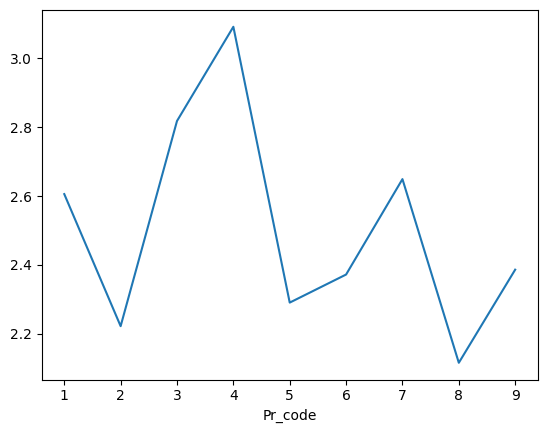

In [38]:
pr_gp['trips-person'].plot()

### Replace value 88/99 or 8/9 to 0

In [12]:
revised_data = ps_data.copy()

for col in col_lst:
    if revised_data[col].drop_duplicates().isin([88, 99]).any():
        replacement_dict = {88: 0, 99: 0}  # Dictionary specifying the replacements
        revised_data[col] = revised_data[col].replace(replacement_dict)
    elif revised_data[col].drop_duplicates().isin([8, 9]).any():
        replacement_dict = {8: 0, 9: 0}  # Dictionary specifying the replacements
        revised_data[col] = revised_data[col].replace(replacement_dict)

    # break

revised_data[col_lst]

,Q24USULWRK,Q24CORSWRK,Q24VFR,Q24TAKE,Q24EDUC,Q24SHOP,Q24LOOKWRK,Q24MEDI,Q24TRADH,Q24WELF,Q24CHURCH,Q24HOME,Q24OTHR
0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,1,0,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
157268,0,0,0,0,0,0,0,0,0,0,0,0,0
157269,0,0,3,0,0,2,0,0,0,0,2,0,0
157270,0,0,0,0,2,0,0,0,0,0,0,8,0
157271,0,0,1,0,0,2,0,0,0,0,0,1,0


In [13]:
revised_data['total_trips'] = revised_data[col_lst].sum(axis=1)
revised_data[col_lst + ['total_trips']]

,Q24USULWRK,Q24CORSWRK,Q24VFR,Q24TAKE,Q24EDUC,Q24SHOP,Q24LOOKWRK,Q24MEDI,Q24TRADH,Q24WELF,Q24CHURCH,Q24HOME,Q24OTHR,total_trips
0,1,0,0,0,0,0,0,0,0,0,0,1,0,2
1,1,0,0,0,0,0,0,0,0,0,0,1,0,2
2,0,0,0,0,1,0,0,0,0,0,0,0,1,2
3,1,0,0,0,0,0,0,0,0,0,0,1,0,2
4,1,0,0,0,0,0,0,0,0,0,0,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157268,0,0,0,0,0,0,0,0,0,0,0,0,0,0
157269,0,0,3,0,0,2,0,0,0,0,2,0,0,7
157270,0,0,0,0,2,0,0,0,0,0,0,8,0,10
157271,0,0,1,0,0,2,0,0,0,0,0,1,0,4


In [14]:
revised_data['total_trips'].sum()

306183

In [15]:
revised_data['person_id'] = revised_data['UQNO'] + revised_data['PERSONNO']

In [16]:
revised_data['person_id'].drop_duplicates()

0         16010009100000450101
1         16010009100000450102
2         16010009100000450103
3         16010009100000930101
4         16010009100000930102
                  ...         
157268    98710648100001120101
157269    98710648100001120102
157270    98710648100001120103
157271    98710648100001250101
157272    98710648100001250102
Name: person_id, Length: 157273, dtype: object

In [17]:
revised_data['UQNO'].drop_duplicates()

0         160100091000004501
3         160100091000009301
5         160100091000011701
6         160100091000016501
10        160100161000000201
                 ...        
157249    987106481000007301
157257    987106481000008601
157262    987106481000009901
157268    987106481000011201
157271    987106481000012501
Name: UQNO, Length: 43462, dtype: object

### trips/person

In [18]:
print('total trips: ', revised_data['total_trips'].sum())
print('trips per person: ', revised_data['total_trips'].sum() / len(revised_data['person_id'].drop_duplicates()))
print('trips per household: ', revised_data['total_trips'].sum() / len(revised_data['UQNO'].drop_duplicates()))
print('persons per household: ', len(revised_data['person_id'].drop_duplicates()) / len(revised_data['UQNO'].drop_duplicates()))

total trips:  306183
trips per person:  1.9468249477024029
trips per household:  7.044843771570568
persons per household:  3.6186323685058213


In [19]:
revised_data['total_trips'].value_counts()

total_trips
2     80919
0     46976
4      7536
3      6268
1      6070
      ...  
35        1
44        1
86        1
43        1
56        1
Name: count, Length: 73, dtype: int64

In [20]:
revised_data[col].drop_duplicates().isin([88,99]).any()

False

### Filter only adults

In [21]:
adult_data = revised_data.loc[ps_data['D_AGE'] >= 18]
adult_data

,UQNO,PERSONNO,TAZCODE,Pr_code,B_NIGHTS,GENDER,D_AGE,RACE,F_HAVELICENCE,G_MOTORCYC,...,undisab,disab,Type,Quintile,totmhinc,Msal,Oldmsal,FULL_CALWGT,total_trips,person_id
0,160100091000004501,01,9001,1,1,2,35,2,2,8,...,0,0,3,3,2100,888888888,888888888,256.707531,2,16010009100000450101
1,160100091000004501,02,9001,1,1,1,38,2,2,8,...,0,0,3,3,2100,2100,2100,256.707531,2,16010009100000450102
3,160100091000009301,01,9001,1,1,1,40,2,2,8,...,0,0,3,4,4192,2096,2096,243.311764,2,16010009100000930101
4,160100091000009301,02,9001,1,1,2,32,2,2,8,...,0,0,3,4,4192,2096,2096,243.311764,2,16010009100000930102
5,160100091000011701,01,9001,1,1,1,62,2,2,8,...,1,1,3,3,1200,888888888,888888888,177.220977,0,16010009100001170101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157265,987106481000009901,04,7002,9,1,2,18,1,2,8,...,0,0,3,2,1760,888888888,888888888,364.815076,2,98710648100000990104
157268,987106481000011201,01,7002,9,1,2,81,1,2,8,...,1,1,3,2,1480,888888888,888888888,178.376568,0,98710648100001120101
157269,987106481000011201,02,7002,9,1,2,30,1,2,8,...,1,1,3,2,1480,888888888,888888888,178.376568,7,98710648100001120102
157271,987106481000012501,01,7002,9,1,2,72,1,2,8,...,0,0,3,3,1200,888888888,888888888,354.767247,4,98710648100001250101


In [22]:
print(adult_data['total_trips'].sum())
print(adult_data['total_trips'].sum() / len(adult_data['person_id'].drop_duplicates()))
print(len(adult_data['person_id'].drop_duplicates()) / len(adult_data['UQNO'].drop_duplicates()))

190456
1.909639641446247
2.2996080239797094


In [23]:
youth_data = revised_data.loc[ps_data['D_AGE'] < 18]
youth_data

,UQNO,PERSONNO,TAZCODE,Pr_code,B_NIGHTS,GENDER,D_AGE,RACE,F_HAVELICENCE,G_MOTORCYC,...,undisab,disab,Type,Quintile,totmhinc,Msal,Oldmsal,FULL_CALWGT,total_trips,person_id
2,160100091000004501,03,9001,1,1,2,9,2,9,9,...,0,0,3,3,2100,888888888,888888888,256.707531,2,16010009100000450103
8,160100091000016501,03,9001,1,1,1,11,2,9,9,...,0,0,3,3,4328,888888888,888888888,253.784526,2,16010009100001650103
9,160100091000016501,04,9001,1,1,1,4,2,9,9,...,8,8,3,3,4328,888888888,888888888,253.784526,2,16010009100001650104
17,160100161000002201,03,9001,1,1,1,10,2,2,8,...,0,1,3,3,3440,888888888,888888888,158.770978,0,16010016100000220103
18,160100161000002201,04,9001,1,1,1,5,2,2,8,...,0,0,3,3,3440,888888888,888888888,158.770978,2,16010016100000220104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157256,987106481000007301,08,7002,9,1,1,5,1,2,8,...,0,0,3,3,6360,888888888,888888888,413.335162,2,98710648100000730108
157261,987106481000008601,05,7002,9,1,1,0,1,2,8,...,8,8,3,2,2680,888888888,888888888,399.467480,0,98710648100000860105
157266,987106481000009901,05,7002,9,1,1,7,1,2,8,...,0,0,3,2,1760,888888888,888888888,364.815076,1,98710648100000990105
157267,987106481000009901,06,7002,9,1,2,4,1,2,8,...,8,8,3,2,1760,888888888,888888888,364.815076,4,98710648100000990106


In [24]:
print(youth_data['total_trips'].sum())
print(youth_data['total_trips'].sum() / len(youth_data['person_id'].drop_duplicates()))
print(len(youth_data['person_id'].drop_duplicates()) / len(youth_data['UQNO'].drop_duplicates()))

115727
2.011279306209701
2.316944511556737


In [25]:
# for i in ps_data.columns:
#     print(i)

## Calculate metrics by modes

In [26]:
for i in ps_data.columns:
    print(i)

UQNO
PERSONNO
TAZCODE
Pr_code
B_NIGHTS
GENDER
D_AGE
RACE
F_HAVELICENCE
G_MOTORCYC
G_CAR
G_HEAVYVEH
Q11ASEE
Q11BHEAR
Q11CWALK
Q11DCONCENTR
Q11ECARE
Q11FCOMM
Q12EYE
Q12HEAR
Q12WALK
Q12WCHAIR
Q12CHRONM
Q12CRUTCH
Q12GUID
Q12PA
Q12OTHR
Q13SOG
Q14OAG
Q14DIS
Q14CSG
Q14CAR
Q14FOST
Q14WARVT
Q14GRN
Q14SOC
Q21MON
Q21TUES
Q21WED
Q21THURS
Q21FRI
Q21SAT
Q21SUN
Q22TRIP
Q23YNOTTRIP
Q24USULWRK
Q24CORSWRK
Q24VFR
Q24TAKE
Q24EDUC
Q24SHOP
Q24LOOKWRK
Q24MEDI
Q24TRADH
Q24WELF
Q24CHURCH
Q24HOME
Q24OTHR
Q25TRAIN
Q25SHOSLZA
Q25BUS
Q25BRT
Q25METTAXI
Q25MINITAXI
Q25LONGTAXI
Q25SEDATAXI
Q25BAKITAXI
Q25CARPAS
Q25CARDRIV
Q25TRUCKPAS
Q25TRUCKDRIV
Q25COMVEH
Q25MBIKE
Q25BICYCLE
Q25ANITRANSP
Q25BOAT
Q25AIRCFT
Q25GAUT
Q25WALK
Q25OTHR
Q26YWALK
Q31HIEDU
Q32ATTE
Q33EDUII
Q34DLRN
Q35APLC
Q35BPROVV
Q35CDISTRCT
Q35dTAZCODE_IMP
Q36DAYS
Q3START_TIMEA
Q38WALKTO
Q39WAIT
Q310WLKEDU
Q3END_TIMEA
Q312MODE1
Q312MODE2
Q312MODE3
Q313MODE1
Q313MODE2
Q313MODE3
Q314MODE1
Q314MODE2
Q314MODE3
Q41WORK
Q42YNOTWRKK
Q43WILTOWRK
Q44APLC
Q44BPROVV


In [27]:
col_lst = [
    'Q25TRAIN', 
    'Q25SHOSLZA', 
    'Q25BUS', 
    'Q25BRT', 
    'Q25METTAXI', 
    'Q25MINITAXI', 
    'Q25LONGTAXI', 
    'Q25SEDATAXI', 
    'Q25BAKITAXI', 
    'Q25CARPAS', 
    'Q25CARDRIV', 
    'Q25TRUCKPAS', 
    'Q25TRUCKDRIV', 
    'Q25COMVEH', 
    'Q25MBIKE', 
    'Q25BICYCLE', 
    'Q25ANITRANSP', 
    'Q25BOAT', 
    'Q25AIRCFT', 
    'Q25GAUT', 
    'Q25WALK', 
    'Q25OTHR', 
]
ps_data

,UQNO,PERSONNO,TAZCODE,Pr_code,B_NIGHTS,GENDER,D_AGE,RACE,F_HAVELICENCE,G_MOTORCYC,...,Q423TOTCST,Q69TOTCST,undisab,disab,Type,Quintile,totmhinc,Msal,Oldmsal,FULL_CALWGT
0,160100091000004501,01,9001,1,1,2,35,2,2,8,...,888888,888888,0,0,3,3,2100,888888888,888888888,256.707531
1,160100091000004501,02,9001,1,1,1,38,2,2,8,...,999999,888888,0,0,3,3,2100,2100,2100,256.707531
2,160100091000004501,03,9001,1,1,2,9,2,9,9,...,888888,888888,0,0,3,3,2100,888888888,888888888,256.707531
3,160100091000009301,01,9001,1,1,1,40,2,2,8,...,888888,888888,0,0,3,4,4192,2096,2096,243.311764
4,160100091000009301,02,9001,1,1,2,32,2,2,8,...,888888,888888,0,0,3,4,4192,2096,2096,243.311764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157268,987106481000011201,01,7002,9,1,2,81,1,2,8,...,888888,888888,1,1,3,2,1480,888888888,888888888,178.376568
157269,987106481000011201,02,7002,9,1,2,30,1,2,8,...,888888,888888,1,1,3,2,1480,888888888,888888888,178.376568
157270,987106481000011201,03,7002,9,1,2,7,1,2,8,...,888888,888888,0,0,3,2,1480,888888888,888888888,178.376568
157271,987106481000012501,01,7002,9,1,2,72,1,2,8,...,888888,888888,0,0,3,3,1200,888888888,888888888,354.767247


### Replace value 88/99 or 8/9 to 0

In [28]:
revised_data = ps_data.copy()
for col in col_lst:
    if revised_data[col].drop_duplicates().isin([88, 99]).any():
        replacement_dict = {88: 0, 99: 0}  # Dictionary specifying the replacements
        revised_data[col] = revised_data[col].replace(replacement_dict)
    elif revised_data[col].drop_duplicates().isin([8, 9]).any():
        replacement_dict = {8: 0, 9: 0}  # Dictionary specifying the replacements
        revised_data[col] = revised_data[col].replace(replacement_dict)

    # break

revised_data[col_lst]

,Q25TRAIN,Q25SHOSLZA,Q25BUS,Q25BRT,Q25METTAXI,Q25MINITAXI,Q25LONGTAXI,Q25SEDATAXI,Q25BAKITAXI,Q25CARPAS,...,Q25TRUCKDRIV,Q25COMVEH,Q25MBIKE,Q25BICYCLE,Q25ANITRANSP,Q25BOAT,Q25AIRCFT,Q25GAUT,Q25WALK,Q25OTHR
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
2,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157268,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157269,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
157270,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
157271,0,0,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
revised_data['total_trips'] = revised_data[col_lst].sum(axis=1)
revised_data

,UQNO,PERSONNO,TAZCODE,Pr_code,B_NIGHTS,GENDER,D_AGE,RACE,F_HAVELICENCE,G_MOTORCYC,...,Q69TOTCST,undisab,disab,Type,Quintile,totmhinc,Msal,Oldmsal,FULL_CALWGT,total_trips
0,160100091000004501,01,9001,1,1,2,35,2,2,8,...,888888,0,0,3,3,2100,888888888,888888888,256.707531,2
1,160100091000004501,02,9001,1,1,1,38,2,2,8,...,888888,0,0,3,3,2100,2100,2100,256.707531,2
2,160100091000004501,03,9001,1,1,2,9,2,9,9,...,888888,0,0,3,3,2100,888888888,888888888,256.707531,2
3,160100091000009301,01,9001,1,1,1,40,2,2,8,...,888888,0,0,3,4,4192,2096,2096,243.311764,2
4,160100091000009301,02,9001,1,1,2,32,2,2,8,...,888888,0,0,3,4,4192,2096,2096,243.311764,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157268,987106481000011201,01,7002,9,1,2,81,1,2,8,...,888888,1,1,3,2,1480,888888888,888888888,178.376568,0
157269,987106481000011201,02,7002,9,1,2,30,1,2,8,...,888888,1,1,3,2,1480,888888888,888888888,178.376568,3
157270,987106481000011201,03,7002,9,1,2,7,1,2,8,...,888888,0,0,3,2,1480,888888888,888888888,178.376568,1
157271,987106481000012501,01,7002,9,1,2,72,1,2,8,...,888888,0,0,3,3,1200,888888888,888888888,354.767247,2


In [30]:
revised_data['total_trips'].sum()

262428

In [31]:
revised_data['person_id'] = revised_data['UQNO'] + revised_data['PERSONNO']

In [32]:
revised_data['person_id'].drop_duplicates()

0         16010009100000450101
1         16010009100000450102
2         16010009100000450103
3         16010009100000930101
4         16010009100000930102
                  ...         
157268    98710648100001120101
157269    98710648100001120102
157270    98710648100001120103
157271    98710648100001250101
157272    98710648100001250102
Name: person_id, Length: 157273, dtype: object

In [33]:
revised_data['UQNO'].drop_duplicates()

0         160100091000004501
3         160100091000009301
5         160100091000011701
6         160100091000016501
10        160100161000000201
                 ...        
157249    987106481000007301
157257    987106481000008601
157262    987106481000009901
157268    987106481000011201
157271    987106481000012501
Name: UQNO, Length: 43462, dtype: object

### trips/person

In [34]:
print('total trips: ', revised_data['total_trips'].sum())
print('trips per person: ', revised_data['total_trips'].sum() / len(revised_data['person_id'].drop_duplicates()))
print('trips per household: ', revised_data['total_trips'].sum() / len(revised_data['UQNO'].drop_duplicates()))
print('persons per household: ', len(revised_data['person_id'].drop_duplicates()) / len(revised_data['UQNO'].drop_duplicates()))

total trips:  262428
trips per person:  1.6686144474893974
trips per household:  6.03810225024159
persons per household:  3.6186323685058213


In [35]:
revised_data['total_trips'].value_counts()

total_trips
2     88275
0     47313
4      8300
1      5312
3      3887
6      1599
5       834
8       482
21      394
10      226
7       221
12      109
9        77
11       74
14       30
23       29
22       23
16       23
20       15
13       12
15       10
24        7
18        7
17        5
26        2
25        2
28        1
38        1
29        1
27        1
19        1
Name: count, dtype: int64

In [36]:
revised_data[col].drop_duplicates().isin([88,99]).any()

False

### Filter only adults

In [37]:
adult_data = revised_data.loc[revised_data['D_AGE'] >= 18]
adult_data

,UQNO,PERSONNO,TAZCODE,Pr_code,B_NIGHTS,GENDER,D_AGE,RACE,F_HAVELICENCE,G_MOTORCYC,...,undisab,disab,Type,Quintile,totmhinc,Msal,Oldmsal,FULL_CALWGT,total_trips,person_id
0,160100091000004501,01,9001,1,1,2,35,2,2,8,...,0,0,3,3,2100,888888888,888888888,256.707531,2,16010009100000450101
1,160100091000004501,02,9001,1,1,1,38,2,2,8,...,0,0,3,3,2100,2100,2100,256.707531,2,16010009100000450102
3,160100091000009301,01,9001,1,1,1,40,2,2,8,...,0,0,3,4,4192,2096,2096,243.311764,2,16010009100000930101
4,160100091000009301,02,9001,1,1,2,32,2,2,8,...,0,0,3,4,4192,2096,2096,243.311764,2,16010009100000930102
5,160100091000011701,01,9001,1,1,1,62,2,2,8,...,1,1,3,3,1200,888888888,888888888,177.220977,0,16010009100001170101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157265,987106481000009901,04,7002,9,1,2,18,1,2,8,...,0,0,3,2,1760,888888888,888888888,364.815076,2,98710648100000990104
157268,987106481000011201,01,7002,9,1,2,81,1,2,8,...,1,1,3,2,1480,888888888,888888888,178.376568,0,98710648100001120101
157269,987106481000011201,02,7002,9,1,2,30,1,2,8,...,1,1,3,2,1480,888888888,888888888,178.376568,3,98710648100001120102
157271,987106481000012501,01,7002,9,1,2,72,1,2,8,...,0,0,3,3,1200,888888888,888888888,354.767247,2,98710648100001250101


In [38]:
print(adult_data['total_trips'].sum())
print(adult_data['total_trips'].sum() / len(adult_data['person_id'].drop_duplicates()))
print(len(adult_data['person_id'].drop_duplicates()) / len(adult_data['UQNO'].drop_duplicates()))

158841
1.5926464395291475
2.2996080239797094


In [39]:
adult_data = revised_data.loc[revised_data['D_AGE'] < 18]
adult_data

,UQNO,PERSONNO,TAZCODE,Pr_code,B_NIGHTS,GENDER,D_AGE,RACE,F_HAVELICENCE,G_MOTORCYC,...,undisab,disab,Type,Quintile,totmhinc,Msal,Oldmsal,FULL_CALWGT,total_trips,person_id
2,160100091000004501,03,9001,1,1,2,9,2,9,9,...,0,0,3,3,2100,888888888,888888888,256.707531,2,16010009100000450103
8,160100091000016501,03,9001,1,1,1,11,2,9,9,...,0,0,3,3,4328,888888888,888888888,253.784526,2,16010009100001650103
9,160100091000016501,04,9001,1,1,1,4,2,9,9,...,8,8,3,3,4328,888888888,888888888,253.784526,2,16010009100001650104
17,160100161000002201,03,9001,1,1,1,10,2,2,8,...,0,1,3,3,3440,888888888,888888888,158.770978,0,16010016100000220103
18,160100161000002201,04,9001,1,1,1,5,2,2,8,...,0,0,3,3,3440,888888888,888888888,158.770978,2,16010016100000220104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157256,987106481000007301,08,7002,9,1,1,5,1,2,8,...,0,0,3,3,6360,888888888,888888888,413.335162,2,98710648100000730108
157261,987106481000008601,05,7002,9,1,1,0,1,2,8,...,8,8,3,2,2680,888888888,888888888,399.467480,2,98710648100000860105
157266,987106481000009901,05,7002,9,1,1,7,1,2,8,...,0,0,3,2,1760,888888888,888888888,364.815076,2,98710648100000990105
157267,987106481000009901,06,7002,9,1,2,4,1,2,8,...,8,8,3,2,1760,888888888,888888888,364.815076,2,98710648100000990106


In [40]:
print(adult_data['total_trips'].sum())
print(adult_data['total_trips'].sum() / len(adult_data['person_id'].drop_duplicates()))
print(len(adult_data['person_id'].drop_duplicates()) / len(adult_data['UQNO'].drop_duplicates()))

103587
1.800291975877231
2.316944511556737


In [41]:
# for i in ps_data.columns:
#     print(i)

# Travel day in the week

In [21]:
ps_data_cols = list(ps_data.columns)
col_lst = ps_data_cols[36:43]
col_lst

['Q21MON', 'Q21TUES', 'Q21WED', 'Q21THURS', 'Q21FRI', 'Q21SAT', 'Q21SUN']

In [23]:
travel_day_df = ps_data[col_lst]
travel_day_df

,Q21MON,Q21TUES,Q21WED,Q21THURS,Q21FRI,Q21SAT,Q21SUN
0,1,1,1,1,1,2,2
1,1,1,1,1,1,2,2
2,1,1,1,1,1,2,2
3,9,1,1,1,1,9,9
4,1,1,1,9,1,9,9
...,...,...,...,...,...,...,...
157268,2,2,1,2,2,1,1
157269,2,2,2,1,1,1,1
157270,1,1,1,1,1,2,2
157271,2,2,2,2,1,1,1


In [24]:
travel_day_df = travel_day_df.replace({2: 0, 9: np.nan})
travel_day_df

,Q21MON,Q21TUES,Q21WED,Q21THURS,Q21FRI,Q21SAT,Q21SUN
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3,NaN,1.0,1.0,1.0,1.0,NaN,NaN
4,1.0,1.0,1.0,NaN,1.0,NaN,NaN
...,...,...,...,...,...,...,...
157268,0.0,0.0,1.0,0.0,0.0,1.0,1.0
157269,0.0,0.0,0.0,1.0,1.0,1.0,1.0
157270,1.0,1.0,1.0,1.0,1.0,0.0,0.0
157271,0.0,0.0,0.0,0.0,1.0,1.0,1.0


In [ ]:
travel_day_df.sum(axis=0).to_csv('../test-outputs/travel_day_df.csv')

<Axes: >

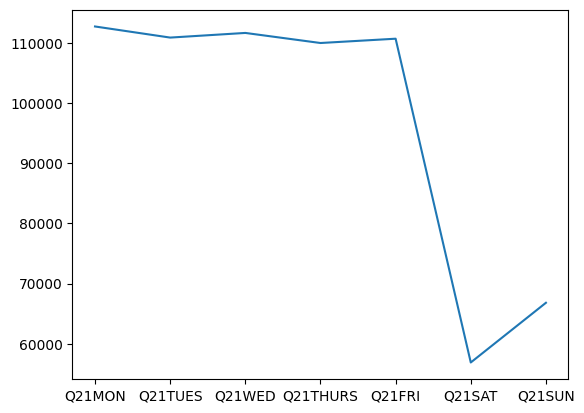

In [35]:
travel_day_df.sum(axis=0).plot()